In [1]:
from importlib import reload
import run_experiment as expt
import uuid
import torch

import numpy as np 
import matplotlib.pyplot as plt



### Tensorboard 

import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple

from torch.distributions import Categorical

import torch
#import torchvision
#import torchvision.transforms as transforms
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from torch.utils.tensorboard import SummaryWriter

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [2]:
import actorcritic as ac
import environment as gw 

In [6]:


def select_action(obs):
    obs = np.expand_dims(obs, axis=0)
    state = torch.Tensor(obs).float()
    p, v, _, __ = agent(state)
    
    m = Categorical(p)
    action = m.sample()
    
    agent.saved_actions.append(SavedAction(m.log_prob(action),v))
    return p,v, action.item()


def finish_ep():
    R = 0
    saved_actions = agent.saved_actions
    p_loss = []
    v_loss = []
    
    returns = []
    for r in agent.rewards[::-1]:
        R = r+ agent.gamma*R
        returns.insert(0,R)
        
    returns = torch.tensor(returns).float()
    
    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        pl = (-log_prob * advantage)
        p_loss.append(pl)

        # calculate critic (value) loss using L1 smooth loss
        rval = Variable(torch.tensor([R])).unsqueeze(-1).unsqueeze(-1)
        vl = F.smooth_l1_loss(value, rval)
        v_loss.append(vl)

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    ploss, vloss = torch.stack(p_loss).sum() , torch.stack(v_loss).sum()
    loss = ploss + vloss
    #writer.add_scalar('Loss/Policy', ploss, trial)
    #writer.add_scalar('Loss/Value', vloss, trial)
    

    # perform backprop
    loss.backward(retain_graph=True)
    optimizer.step()
    
    #for name, param in agent.named_parameters():
    #    writer.add_histogram(name, param.grad, trial)
    
    # reset rewards and action buffer
    del agent.rewards[:]
    del agent.saved_actions[:]
    return ploss, vloss

In [7]:
reload(ac)
PL,VL = [], []
rt = [] 
ep = expt.basic_env_params()

env = gw.GridWorld(rows=20, cols=20, env_type=ep.env_type,
                           rewards={ep.reward_location: ep.reward_mag},
                           step_penalization=ep.penalty,
                           rho=ep.rho,
                           actionlist=ep.actionlist,
                           rewarded_action=ep.rewarded_action)
#agent = ac.linAC()
agent = ac.convAC()
#agent = ac.ActorCritic(expt.basic_agent_params(env).__dict__)
optimizer = optim.Adam(agent.parameters(), lr=1e-1)


In [8]:

ntrials = 1000
nevents = 250

# default `log_dir` is "runs" - we'll be more specific here
#writer = SummaryWriter('runs/fml')
for trial in range(ntrials):
    env.resetEnvironment()
    ep_reward = 0
    for event in range(nevents):
        state = env.get_observation()
        p, v, choice = select_action(state)
        action = env.action_list[choice][0]
        next_state, reward, done = env.move(action)
        
        agent.rewards.append(reward)
        ep_reward += reward
        if done:
            break
    rt.append(ep_reward)
    if trial%10==0:
        print(f'trial{trial}: R={ep_reward} in {event+1} steps')
    # finish episode
    pl, vl = finish_ep()
    PL.append(pl)
    VL.append(vl)
    

trial0: R=9.07 in 94 steps


<ipython-input-6-2fb23805a1d7>:35: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  vl = F.smooth_l1_loss(value, rval)


trial10: R=-2.4999999999999907 in 250 steps
trial20: R=-2.4999999999999907 in 250 steps
trial30: R=-2.4999999999999907 in 250 steps
trial40: R=-2.4999999999999907 in 250 steps
trial50: R=-2.4999999999999907 in 250 steps
trial60: R=-2.4999999999999907 in 250 steps
trial70: R=-2.4999999999999907 in 250 steps
trial80: R=-2.4999999999999907 in 250 steps
trial90: R=-2.4999999999999907 in 250 steps
trial100: R=-2.4999999999999907 in 250 steps
trial110: R=-2.4999999999999907 in 250 steps
trial120: R=-2.4999999999999907 in 250 steps
trial130: R=-2.4999999999999907 in 250 steps
trial140: R=-2.4999999999999907 in 250 steps
trial150: R=-2.4999999999999907 in 250 steps
trial160: R=-2.4999999999999907 in 250 steps
trial170: R=-2.4999999999999907 in 250 steps
trial180: R=-2.4999999999999907 in 250 steps
trial190: R=-2.4999999999999907 in 250 steps
trial200: R=-2.4999999999999907 in 250 steps
trial210: R=-2.4999999999999907 in 250 steps
trial220: R=-2.4999999999999907 in 250 steps
trial230: R=-2.4999

(3, 20, 20)


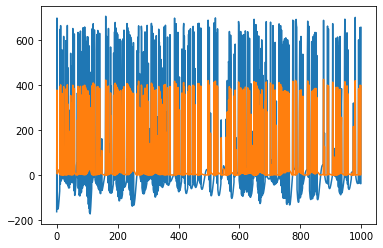

In [18]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(PL)
ax[0].plot(VL)
ax[1].plot(rt)

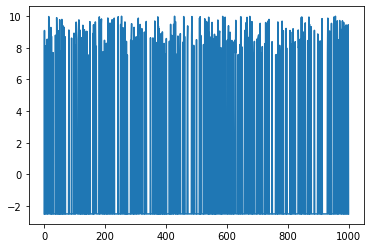

In [14]:
pols, vals = expt.get_snapshot(env.get_sample_obs(), env, agent)
gp.plot_polmap(env, pols)
gp.plot_valmap(env, vals, v_range=[0,10])

In [ ]:
reload(expt)
print(test(observation))
writer.add_graph(test, input_to_model=[observation])
ex = expt.training()
observation = torch.Tensor(np.expand_dims(ex.env.get_observation(), axis=0))

#writer.close()

In [ ]:
ex.run(1000,250)

In [ ]:
NUM_TRIALS = 5000
NUM_EVENTS = 250

run_id = uuid.uuid4()
ex.run(NUM_TRIALS,NUM_EVENTS)


In [ ]:
agent = train_expt.agent
env = train_expt.env

samples, states = env.get_sample_obs()

if agent.use_SR: 
    p, v, phi, psi = agent(torch.Tensor(samples))
else: 
    p, v, psi  = agent(torch.Tensor(samples))
    
activias = phi

In [ ]:
x = np.zeros(env.shape)
x[:,:] = np.nan
monstro = np.asarray([x for i in range(len(activias[0]))])

for ind, state in enumerate(states):
    row = state[0]
    col = state[1]
    
    for index, item in enumerate(activias[ind]):
        monstro[index, row, col] = item

In [ ]:
from matplotlib import cm
import matplotlib.colors as colors 
import matplotlib.colorbar as colorbar

from environment import plotting as gp

fig, ax = plt.subplots(14,14, sharex=True, sharey=True, figsize=(6,6))

cmap = cm.viridis
cNorm = colors.Normalize(vmin=np.nanmin(monstro), vmax=np.nanmax(monstro))

for i, a in enumerate(ax.flat):
    a.imshow(monstro[i], cmap=cmap)#, norm=cNorm)
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])
    a.annotate(xy=(5,10), text=f"{i}", color='white')
    
plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
from scipy.spatial import distance as d

cos_sims = np.zeros((20,20))
cos_sims[:] = np.nan
iind = 1
for state, activity in zip([states[iind]],[activias[iind]]):
    print(state)
    for sref, ref in zip(states, activias):
        cs = 1 - d.cosine(ref.detach().numpy(), activity.detach().numpy())
        cos_sims[sref[0], sref[1]] = cs
    
    plt.figure()
    plt.imshow(cos_sims)
    plt.colorbar()
    plt.show()
    plt.close()

In [ ]:
from importlib import reload
import sys
import actorcritic as ac
import environment as gw
import memory as ec

sys.modules['gw'] = gw
sys.modules['ac'] = ac
# TODO -- need to do this for all imported modules????

import run_experiment as expt

import pickle
import pandas as pd
import uuid
from analysis import DataFilter

In [ ]:
reload(expt)
train_expt = expt.training()
test

In [ ]:
reload(expt)
reload(ec)
reload(gw)
#experiment_type = 4 ############
env_type     = None
rho          = 0.0
arch         = 'B'
rwd_mag      = 10


use_pvals    = False
mem_temp     = 0.5
mem_envelope = 50
alpha        = 1
beta         = 100000

move_reward = False
remap_transitions = False

#action_list = ['Down', 'Up', 'Right', 'Left', 'Jump', 'Poke']
action_list = ['Down', 'Up', 'Right', 'Left']


RECORD       = False

NUM_TRIALS = 5000
NUM_EVENTS = 250

for mem_temp in [1]:
    experiment_type = 4 ##################### 
    parent_dir = './data/'
    log_file = 'sep2020.csv'

    # set environment parameters
    rows, columns = 20, 20
    penalty = -0.01
    if experiment_type == 0:
        reward_location = (5, 5)
    else:
        if move_reward:
            reward_location = (15, 15)
        else:
            reward_location = (5,5)


    # generate environment object
    env = gw.GridWorld(rows=rows, cols=columns, env_type=env_type,
                       rewards={reward_location: rwd_mag},
                       step_penalization=penalty,
                       rho=rho,
                       actionlist=action_list
                      )
    print(env.action_list)
    # agent parameters
    training = {
        'load_model': False,
        'load_dir': '',

        'architecture': arch,
        'input_dims': env.observation.shape,
        'action_dims': len(env.action_list),
        'hidden_types': ['conv', 'pool', 'conv', 'pool', 'linear', 'linear'],
        'hidden_dims': [None, None, None, None, 100, 200],

        'freeze_w': False,

        'rfsize': 5,

        'gamma': 0.98,
        'eta': 5e-4,

        'use_EC': False
    }

    testing_1 = training.copy()
    testing_1.update({'load_model': True, 'freeze_w': True})

    testing_2 = testing_1.copy()
    testing_2.update({'use_EC': True})

    testing_4 = testing_1.copy()
    testing_4.update({'freeze_w': False})

    testing_5 = testing_4.copy()
    testing_5.update({'use_EC': True})

    params = [training, testing_1, testing_2, testing_2, testing_4, testing_5, testing_5]

    # mixing parameters for MF-EC control
    # alpha = 0.01 # MF confidence boost for reward
    # beta = 100 # MF confidence decay - number of steps to decay to 1%

    # create an agent with parameters for a given experiment type
    agent_params = params[experiment_type]
    load_id = ' '
    if experiment_type != 0:
        # read csv file - get id tag for matching conditions
        df = pd.read_csv(parent_dir + log_file)
        filter = DataFilter(df,
                            expt_type=[0],
                            env_type=[str(env_type)],
                            dims=[str(env.shape)],
                            rho=[float(env.rho)],
                            rewards=[f'{{(5, 5): {rwd_mag}}}'],
                            action_list=[str(action_list)],
                            arch=[arch])

        load_id = list(filter.ids)[0] #np.random.choice(len(list(filter.ids)))
        agent_params['load_dir'] = parent_dir + f'agent_weights/{load_id}.pt'
        print(f'loading weights from {load_id}')
        
        env = pickle.load(open(parent_dir + f'environments/{load_id}_env.p', 'rb'))
        rwd_ = float(filter.info.iloc[0]['rewards'].strip('{}').split(':')[1])
        # set new reward location and update env.R accordingly 
        env.step_penalization = penalty
        env.rewards = {reward_location: rwd_}
        env.buildRewardFunction()
        env.finish_after_first_reward = True
        
        if remap_transitions:
            env.remapTransitionMatrix()

    agent = ac.make_agent(agent_params)
    #load_id = '4a37792b-8b25-4565-8819-4e047c8813da'
    #env = pickle.load(open(parent_dir + f'environments/{load_id}_env.p', 'rb'))
    if experiment_type in [2, 3, 5, 6, 12, 15]:
        # create memory module
        
        mem = ec.EpisodicMemory(cache_limit=400,
                                entry_size=agent.action_dims,
                                mem_temp=mem_temp,
                                mem_envelope=mem_envelope,
                                pvals=use_pvals)
    else:
        mem = None
        
    
    gp.plot_world(env, plotNow=True, scale=0.3)
    # create run_id
    run_id = uuid.uuid4()
    # create experiment object
    ex = expt.Experiment(agent, env, use_mem=agent_params['use_EC'], mem=mem)

    # run experiment
    ex.run(NUM_TRIALS, NUM_EVENTS, alpha=alpha, beta=beta, get_samples=True, printfreq=100)
    
    # log data
    if RECORD:
        if remap_transitions:
            experiment_type += 10
        expt.data_log(log_file, run_id, experiment_type, ex, load_from=load_id)

In [ ]:
reload(gp)
for index in [0]: #range(len(ex.data['total_reward'])):
    ec_pol_map = ex.data['val_tracking'][index]
    mf_pol_map = ex.data['pol_tracking'][index]
    #
    gp.plot_valmap(ex.env, ec_pol_map, v_range=[0,10])
    gp.plot_polmap(ex.env, mf_pol_map, threshold = 0.2)
    #gp.plot_valmap(ex.env, val_map, title=str(index), save=True, v_range=[0,10])
    
    #gp.plot_pref_pol(ex.env, ec_pol_map, upperbound=1.5, save=False, title=str(index))
    gp.plot_pref_pol(ex.env, mf_pol_map, upperbound=2)

In [ ]:
reload(gp)
for index in [3]: #range(len(ex.data['total_reward'])):
    ec_pol_map = ex.data['ec_tracking'][index]
    mf_pol_map = ex.data['pol_tracking'][index]
    #
    gp.plot_polmap(ex.env, ec_pol_map, threshold = 0.2)
    gp.plot_polmap(ex.env, mf_pol_map, threshold = 0.2)
    #gp.plot_valmap(ex.env, val_map, title=str(index), save=True, v_range=[0,10])
    
    gp.plot_pref_pol(ex.env, ec_pol_map, upperbound=1.5, save=False, title=str(index))
    gp.plot_pref_pol(ex.env, mf_pol_map, upperbound=1.5)
    

In [ ]:
from fxns import running_mean
print(ex.data.keys())
fig, ax = plt.subplots(2,1, sharex=True)
smoothing = 10
ax[0].plot(running_mean(ex.data['total_reward'],smoothing),'r')
ax[1].plot(running_mean(ex.data['loss'][0], smoothing), label='P')
ax[1].plot(running_mean(ex.data['loss'][1], smoothing), label='V')
ax[1].legend(bbox_to_anchor=(1.05, 0.95))


In [ ]:
print(ex.data['confidence_selection'][0])

In [ ]:
def plot_trajectory(trajectory):
    
    fig = plt.figure(figsize=(8,8))
    plt.pcolor(ex.env.grid,cmap='bone', vmax=1, vmin=0)
    ax = fig.gca()
    ax.set_aspect('equal')

    ax.add_patch(plt.Rectangle((15,15), width=0.99, height=1, linewidth=1, ec='white', fill=False))
    rows = trajectory[:,0]
    cols = trajectory[:,1]
    ax.add_patch(plt.Rectangle((rows[0],cols[0]), width=0.99, height=1, linewidth=1, ec='red', fill=False))
    dx, dy = [],[]
    for ind in range(len(rows)-1):
        dx.append(rows[ind+1]-rows[ind])
        dy.append(cols[ind+1]-cols[ind])

    dx = np.asarray(dx)*0.25
    dy=np.asarray(dy)*0.25
    for i in range(10):#len(dx)):
        plt.arrow(rows[i]+0.5,cols[i]+0.5, dx[i], dy[i], head_width=0.2, head_length=0.2, color='white',alpha=0.5)

    ax.invert_yaxis()
    plt.show()


In [ ]:

sar = ex.data['sar'][0:200]



for j in range(2):#len(sar)):
    i = j + 4
    if sum(np.vstack(sar[i])[:,3]) <0: 
        print(np.vstack(sar[i])[0,0])
        rpe_data = ex.data['rpe_tracking'][i]
        expt.plot_valmap(ex.env, rpe_data.T)
        trajectory = np.vstack(sar[i])[:,0]
        plot_trajectory(np.vstack(trajectory))




In [ ]:
policies = ex.data['pol_tracking']
values = ex.data['val_tracking']

In [ ]:
load_data = pickle.load(open(parent_dir + f'results/{run_id}_data.p', 'rb'))
load_data['sar'] = []
t_to_date = load_data['trials_run_to_date']
for key in load_data.keys():
    if key == 'trials_run_to_date':
        load_data[key] += ex.data[key]
    elif len(load_data[key]) == t_to_date:
        load_data[key] += ex.data[key]
    else:
        for i in range(len(load_data[key])):
            load_data[key][i] += ex.data[key][i]

for i in load_data.keys():
    print(type(load_data[i]), i )


In [ ]:
#pickle.dump(load_data, open(f'{parent_dir}results/{run_id}_data.p', 'wb'))

In [ ]:
ex.run(50000, NUM_EVENTS, alpha=alpha, beta=beta)

In [ ]:
expt.data_log(log_file,run_id, experiment_type, ex, load_from=load_id)

In [ ]:
import torch
mem_location = (13,13)
observation = torch.Tensor(np.expand_dims(ex.env.get_observation(agtlocation=mem_location), axis=0))
policy_, value_, phi_, psi_ = ex.agent(observation)
lin_act = tuple(np.round(psi_.data[0].numpy(), 4))

ex.episodic.recall_mem(lin_act, timestep=0)

In [ ]:
print(ex.data['visited_states'][0:2])



In [ ]:
reload(gp)
pols, vals = expt.get_snapshot(env.get_sample_obs(), env, agent)
gp.plot_polmap(env, pols)
gp.plot_valmap(env, vals, v_range=[0,10])

In [ ]:
ex.run(10000,250,reset_data=True)

In [ ]:
from fxns import running_mean
plt.plot(running_mean(ex.data['total_reward'],30))

In [ ]:
#run_id = uuid.uuid4()
#expt.data_log(run_id, experiment_type, ex, load_from=load_id)

In [ ]:
from fxns import running_mean
pen = env.step_penalization
rewards = np.vstack(ex.data['sar'])[:,2]

z_rewards = rewards.copy()
for ind, i in enumerate(z_rewards):
    if i <0:
        z_rewards[ind] = 0.0

cs = []
ex.MF_cs = 0
for i in z_rewards:
    ex.policy_arbitration(i)
    cs.append(ex.MF_cs)
    
plt.figure()
plt.plot(rewards, "r|")
plt.plot(ex.data['confidence_selection'][0], 'b', label='with step penalization')
plt.plot(cs, 'g', label='without step penalization')

plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.title(f'Penalization={pen}, alpha={alpha}, beta={beta}')
#xstart = 6000
#plt.xlim([xstart,xstart+500])
plt.show()
plt.close()

In [ ]:
#### trying some craziness -- delete later (Jul 24)
plt.figure()
x = ex.data['confidence_selection'][0] # MFCS
y = ex.data['confidence_selection'][1] # policy_choice
viridis = cm.get_cmap('inferno', len(x)).colors
plt.scatter(x, y, c = viridis, alpha=0.3, edgecolor='k')
plt.yticks([0,1], ['MF', 'EC'])
plt.ylim([-0.5, 1.5])
plt.xlim([0,1])
plt.show()
plt.close()

plt.figure()
x = ex.data['confidence_selection'][0] # MFCS
y = ex.data['confidence_selection'][1] # policy_choice
viol = [[],[]] #mf ec

for ind, i in enumerate(x):
    viol[y[ind]].append(i)

print(viol)
plt.figure()
plt.violinplot(viol, positions = [0,1], vert=False, showmeans=True)
plt.xlim([0,0.1])
plt.yticks([0,1], [f'MF (n={len(viol[0])})', f'EC (n={len(viol[1])})'])
plt.show()
plt.close()

plt.figure()
y = ex.data['confidence_selection'][0] # MFCS
x = np.arange(len(y))
cols = ['b', 'g'] #mf , ec
z = ex.data['confidence_selection'][1] # policy_choice
col = [cols[i] for i in z]

plt.scatter(x, y, c = col, alpha=0.3)
plt.show()
plt.close()

In [ ]:
from ipywidgets import interactive
%matplotlib inline


def g(x):
    plt.plot(rewards, 'r|')
    plt.plot(ex.data['confidence_selection'][0], 'b')
    plt.plot(cs, 'g')
    plt.xlim(x, x+500)
    plt.show()

interactive_plot = interactive(g, x=(0,len(rewards)-500,500))
interactive_plot

In [ ]:
mpol_array = np.zeros(env.grid.shape, dtype=[(x, 'f8') for x in env.action_list])

for i in mem.cache_list.keys():
    values = mem.cache_list[i]
    row, col = values[2]
    pol = mem.recall_mem(i, timestep=0)
    mpol_array[row, col] = tuple(pol)
    
from environment import plotting
reload(plotting)
plotting.plot_pref_pol(env, mpol_array)



In [ ]:
print(ex.data['confidence_selection'][0])

In [ ]:
a = ['MF', 'EC']
for x,y in zip(np.vstack(ex.data['sar']), ex.data['confidence_selection'][1]):
    print(x, a[y])

In [ ]:
plt.plot(ex.data['total_reward'])

In [ ]:
## example decay curves 
alpha = 0.01
beta = 10000
ex = expt.Experiment(agent, env, alpha = alpha, beta = beta)
# 100 instances 
prob = 0.15
num = 100
pen = -0.01
n_rewards = np.random.choice([pen,1], num, p=[1-prob, prob])
z_rewards = n_rewards.copy()
z_rewards[z_rewards == pen] = 0

n_cs = []
z_cs = []
for i in n_rewards:
    ex.policy_arbitration(i)
    n_cs.append(ex.MF_cs)

for j in z_rewards:
    ex.policy_arbitration(j)
    z_cs.append(ex.MF_cs)

plt.figure()
plt.plot(n_rewards, "r|")
plt.plot(z_rewards, "b|")
plt.plot(n_cs, 'r', label='with penalization in MFCS')
plt.plot(z_cs, 'b', label='no penalization in MFCS')
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.title(f'Penalization={pen}, alpha={alpha}, beta={beta}')
plt.show()
plt.close()

x = np.subtract(z_cs, n_cs)
plt.figure()
plt.plot(n_rewards, 'k|')
plt.plot(x)
plt.show()
plt.close()

In [ ]:
print(n_rewards, z_rewards)